In [1]:
#! python -m spacy download ru_core_news_lg

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.ru.examples import sentences 
from spacy.matcher import Matcher

import ru_core_news_lg  
nlp = ru_core_news_lg.load()

# Содержание. Content
1. Загрузка данных. Load data

2. Извлечение реплик с приветствием – где менеджер поздоровался. 
Extract greeting lines - where the manager said hello

3. Извлечение реплик, где менеджер представил себя.
Extract the lines where the manager introduced himself.

4. Извлечение имени менеджера.
Retrieve the manager's name.

5. Извлечение названия компании
Company name extraction

6. Извлечение реплик, где менеджер попрощался.
Extraction of replicas where the manager said goodbye.

7. Проверка требований к менеджеру: «В каждом диалоге обязательно необходимо поздороваться и попрощаться с клиентом»
Checking the requirements for the manager: “In every dialogue, it is imperative to say hello and say goodbye to the client”

## 1. Загрузка данных. Load data

In [3]:
data = pd.read_csv('/content/test_data.csv')
data.head(2)

,dlg_id,line_n,role,text
0,0,0,client,Алло
1,0,1,manager,Алло здравствуйте


In [4]:
data.shape

(480, 4)

In [5]:
data.isnull().sum()

dlg_id    0
line_n    0
role      0
text      0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data.dtypes

dlg_id     int64
line_n     int64
role      object
text      object
dtype: object

In [8]:
data['text'] = data['text'].astype('str')
data['role'] = data['role'].astype('str')

In [9]:
data.dlg_id.nunique()

6

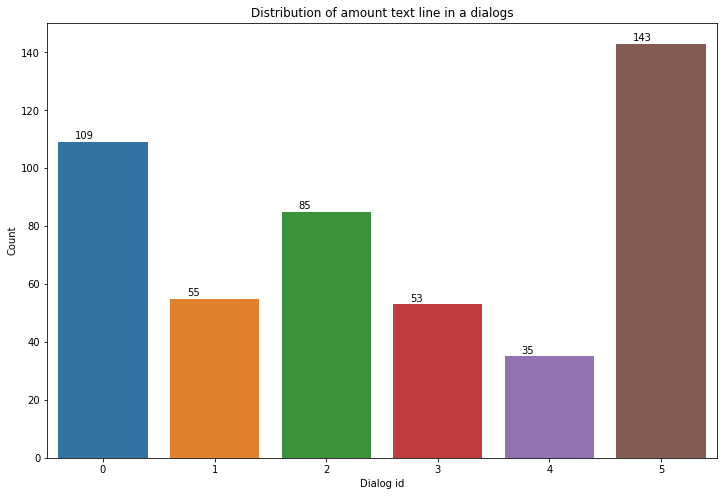

In [10]:
plt.figure(figsize=(12,8))

ax = sns.countplot(x="dlg_id", data=data)

plt.title('Distribution of amount text line in a dialogs')
plt.xlabel('Dialog id')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

В данных представлены скрипты  для 6 диалогов между менеджером и клиентом.

Размер датафрейма 480 x 4.

Самый котроткий диалог - 4-й, содержит всего 35 строк.

Долгий диалог  - диалог №5.Он состоит их 143 строк. 

Данные предобработаны и достаточно "чистые":  

*   отсутствуют пропуски и пустые значения
*   отсутствуют html-теги и эмодзи
*   отсутствуют знаки пунктуации

##2. Извлечение реплик с приветствием – где менеджер поздоровался. 
Extract greeting lines - where the manager said hello

In [11]:
# Посмотрим на первую реплику в 0 диалоге
# Let's look at the first text line in a dialog №0

data.query('dlg_id == 0 & role == "manager"').reset_index().text[0]

'Алло здравствуйте'

In [12]:
# вызовем Matcher()
# call the Matcher() method
matcher = Matcher(nlp.vocab)

# пропишем правила для поиска приветствий
# write rules for finding greetings
pattern_gr = [{"TEXT": {"REGEX": "(привет|здравствуйте|здравствуй|приветствую)"}}]
matcher.add("greetings", [pattern_gr])

pattern_gr2 = [{"LEMMA": {"IN": ["добрый", "доброе"]}}, {"POS": "NOUN", "LENGTH": {"<=": 5}} ]
matcher.add("greetings", [pattern_gr2])

pattern_gr3 = [{"POS": "NOUN", "LENGTH": {"<=": 5}}, {"LEMMA": {"IN": ["добрый", "доброе"]}} ]
matcher.add("greetings", [pattern_gr3])

In [13]:
# функция для поиска приветствий
# function for searching greetings

def get_greeting(string_):
  doc_ = nlp(string_)
  matches = matcher(doc_, as_spans=True)
  for span in matches:
    return span.text


In [14]:
# добавим колонку в датафрейме для записи приветствий
# let's find and adding greetings in dataframe

data['greetings'] =  ['no' for el in data.text]

In [15]:
# Найдем приветствие менеджера и сохраним в датафрейм
# Find greetings and add them to dataframe

dlg_number = data.dlg_id.unique()  # all dialogs

for dlg in dlg_number:
  texts = data.query('dlg_id == @dlg & role == "manager"').text[0:1]
  indexes = texts.index
  for num, dlg_text in enumerate(texts):    
    name = get_greeting(dlg_text)
    if name is not None:
      data.at[indexes[num],'greetings'] = name  # update value in dataframe

In [16]:
# уникальные значения
# unique values
data.greetings.unique()

array(['no', 'здравствуйте', 'добрый день'], dtype=object)

In [17]:
data.head(2)

,dlg_id,line_n,role,text,greetings
0,0,0,client,Алло,no
1,0,1,manager,Алло здравствуйте,здравствуйте


##3. 	Извлечение реплик, где менеджер представил себя.
Extract the lines where the manager introduced himself.

Под "представлением себя" будем понимать имя и место работы менеджера 

By "introducing yourself", we mean the name and place of work of the manager

In [18]:
data.query('dlg_id == 0 & role=="manager"').reset_index().text[1]

'Меня зовут ангелина компания диджитал бизнес звоним вам по поводу продления лицензии а мы с серым у вас скоро срок заканчивается'

In [19]:
def self_presentation(string_):
  tmp_results = []
  doc = nlp(string_)

  matcher = Matcher(nlp.vocab)
  # шаблоны для поиска 
  # Да это анастасия
  pattern = [{"POS": "PRON"}, {"POS": "PROPN"}]
  matcher.add("sich_vorschtellen1", [pattern])

  # меня зовут ангелина компания диджитал бизнес
  pattern2 = [{"POS": "PRON"},{"POS": "VERB"}, {"POS": "PROPN"}, {"POS": "NOUN"}, {"POS": "VERB"}, {"POS": "NOUN"}]
  matcher.add("sich_vorschtellen2", [pattern2])

  # меня ангелина зовут компания китобизнес
  pattern3 = [{"POS": "PRON"},{"POS": "PROPN"}, {"POS": "VERB"}, {"POS": "NOUN"}, {"POS": "PROPN"}]  
  matcher.add("sich_vorschtellen3", [pattern3])

  # ангелина меня зовут
  pattern4 = [{"POS": "PROPN"},{"POS": "PRON"}, {"POS": "VERB"}]
  matcher.add("sich_vorschtellen2", [pattern4])

  # ангелина зовут меня
  pattern5 = [{"POS": "PROPN"},{"POS": "VERB"}, {"POS": "PRON"}]
  matcher.add("sich_vorschtellen2", [pattern5])

   # меня ангелина зовут компания диджитал бизнес
  pattern6 = [{"POS": "PRON"},{"POS": "PROPN"}, {"POS": "VERB"}, {"POS": "NOUN"}, {"POS": "VERB"}, {"POS": "NOUN"}]  
  matcher.add("sich_vorschtellen6", [pattern6])

  # меня зовут ангелина компания китобизнес
  pattern7 = [{"POS": "PRON"},{"POS": "VERB"}, {"POS": "PROPN"},{"POS": "NOUN"}, {"POS": "PROPN"}]
  matcher.add("sich_vorschtellen2", [pattern7])

  matches = matcher(doc, as_spans=True)
  for span in matches:
    tmp_results.append(span.text)
  
  try:
    max_len = max(len(x) for x in tmp_results) # find out the max length
    res = [x for x in tmp_results if len(x) == max_len]
    return res[0]
  except:
    return None

In [20]:
# добавим колонку в датафрейме для записи представлений менеджеров
# add new column 

data['self_presentation'] =  ['no' for el in data.text]

In [21]:
# Найдем представления менеджеров для каждого диалога и сохраним в таблицу 
# Find managers self-presentation and add them to dataframe

dlg_number = data.dlg_id.unique()  # all dialogs

for dlg in dlg_number:
  texts = data.query('dlg_id == @dlg & role == "manager"').text[0:2]
  indexes = texts.index
  for num, dlg_text in enumerate(texts): 
    name = self_presentation(dlg_text)
    if name is not None:
      data.at[indexes[num], 'self_presentation'] = name  # update value in dataframe

In [22]:
# проверим результат
# check the result

data.loc[251:252,['role','text', 'self_presentation']]

,role,text,self_presentation
251,manager,Добрый меня максим зовут компания китобизнес у...,меня максим зовут компания китобизнес
252,client,Да удобно,no


##4. Извлечение имени менеджера.
Retrieve the manager's name.

In [23]:
# функция для извлечения сушностей "Person"
# function for getting Person entities

def get_entities(doc_):
  for ent in doc_.ents:
    if ent.label_ == 'PER':
      return ent.text

In [24]:
# напишем правила для поиска персон в тексте
# write rules for searching "person" in text

matcher = Matcher(nlp.vocab)
pattern = [{"LOWER": "это"}, {"POS": "PROPN"}]
matcher.add("PER_", [pattern])

In [25]:
# функция для получения имени менеджера
# function for getting manager name

def get_manager_name(string_):
  NoneType = type(None)
  doc__ = nlp(string_)
  ner = get_entities(doc__) 

  if isinstance(ner, NoneType):
    matches = matcher(doc__, as_spans=True)
    for span in matches:
      return span.text[4:]
  else:
    return ner

In [26]:
# создадим колонку для сохранения результатов
# create table for saving managers name

data['manager_name'] =  ['no' for el in data.text]

In [27]:
# Найдем имена менеджеров для каждого диалога и сохраним в таблицу 
# Find managers name and add them to dataframe

dlg_number = data.dlg_id.unique()  # all dialogs

for dlg in dlg_number:
  texts = data.query('dlg_id == @dlg & role == "manager"').text[0:2]
  indexes = texts.index
  for num, dlg_text in enumerate(texts):    
    name = get_manager_name(dlg_text)
    if name is not None:
      data.at[indexes[num],'manager_name'] = name  # update value in dataframe

In [28]:
# проверим
# check

data.loc[338:340,['role','text', 'manager_name']]

,role,text,manager_name
338,manager,Да это анастасия,анастасия
339,client,Смотрите мы сейчас уже нашли как бы да мы всю ...,no
340,manager,Угу,no


In [29]:
data.head(2)

,dlg_id,line_n,role,text,greetings,self_presentation,manager_name
0,0,0,client,Алло,no,no,no
1,0,1,manager,Алло здравствуйте,здравствуйте,no,no


In [30]:
# посмотрим на уникальные значения
# lets look for unique values
data.manager_name.unique()

array(['no', 'ангелина', 'максим', 'анастасия'], dtype=object)

##5. Извлечение названия компании
Company name extraction

In [31]:
# функция для получения имени компании (встроенный метод в spacy)
# function for getting companys name (NER in spacy)

def get_entities_ORG(string_):
  doc_ = nlp(string_)
  for ent in doc_.ents:
    if ent.label_ == 'ORG':
      return ent.text

In [32]:
# опишем правила по которым будем искать названия компаний
# write the rules for finding a companys name

matcher = Matcher(nlp.vocab)
pattern = [{"LEMMA": {"IN": ["компания", "агентство"]}}, {"POS": "PROPN" }]
matcher.add("Company", [pattern])

pattern1 = [{"LEMMA": {"IN": ["компания", "агентство"]}}, {"POS": "VERB" }, {"POS": "NOUN" }]
matcher.add("Company", [pattern1])

pattern2 = [{"LEMMA": {"IN": ["компания", "агентство"]}}, {"POS": "NOUN" }, {"POS": "CONJ" }, {"POS": "NOUN" }]
matcher.add("Company", [pattern2])

pattern3 = [{"LEMMA": {"IN": ["компания", "агентство"]}}, {"POS": "ADJ" }, {"POS": "NOUN" }]
matcher.add("Company", [pattern3])

In [33]:
# функция для поиска имен компаний с использованием описанных выше правил
# geting company name by using Matcher()

def match_company_name(string_):
  doc_ = nlp(string_)
  matches = matcher(doc_)
  matches = matcher(doc_, as_spans=True)
  for span in matches:
    return span.text

In [34]:
# итоговая функция для получения имен компаний
# combine 2 previous functions for getting company name

def get_company_name(string_):
  ner_name = get_entities_ORG(string_)
  if ner_name is None:
    return match_company_name(string_)
  else:
    return ner_name

In [35]:
# добавим колонку в датафрейме для записи приветствий 
# add new column

data['company'] =  ['no' for el in data.text]

In [36]:
# Найдем имена компаний для каждого диалога и сохраним в таблицу 
# Find company names and add them to dataframe

dlg_number = data.dlg_id.unique()  # all dialogs

for dlg in dlg_number:
  texts = data.query('dlg_id == @dlg & role == "manager"').text[0:2]
  indexes = texts.index
  for num, dlg_text in enumerate(texts):    
    name = get_company_name(dlg_text)
    if name is not None:
      data.at[indexes[num],'company'] = name  # update value in dataframe

In [37]:
# посмотрим на перечень уникальных компаний
# let's look to the unique companys

data.company.unique()

array(['no', 'компания диджитал бизнес', 'компания китобизнес'],
      dtype=object)

In [38]:
# посмотрим на резкльтат
# check the result

data.loc[167:168,['role','text', 'company']]

,role,text,company
167,manager,Меня зовут ангелина компания диджитал бизнес з...,компания диджитал бизнес
168,manager,А нет я еще не отправляла я решила вам набрать,no


##6. Извлечение реплик, где менеджер попрощался.
Extraction of replicas where the manager said goodbye.

In [39]:
# вызовем Matcher()
# call the method Matcher()

matcher = Matcher(nlp.vocab)

# пропишем правила для поиска прощаний  (берем официальную лексику, используемую при прощании)
# write rules for finding farewells

pattern_farewell = [{"LOWER": "до"}, {"LEMMA": {"IN": ["свидание", "встреча"]}}]
matcher.add("farewell", [pattern_farewell])

pattern_farewell2 = [{"LOWER": "всего"}, {"LEMMA": {"IN": ["добрый", "наилучший", "хороший"]}}]
matcher.add("farewell", [pattern_farewell2])

In [40]:
# функция для поиска 
# function for finfing farewells

def get_farewell(string_):
  farewell = []
  doc_ = nlp(string_)
  matches = matcher(doc_, as_spans=True)
  for span in matches:
    farewell.append(span.text)
  if len(farewell)==1:
    return farewell[0]
  if len(farewell)>1:
    return ' '.join(farewell)
  else:
    return None

In [41]:
# добавим колонку в датафрейме для записи прощаний
# add new column in dataframe

data['farewells'] =  ['no' for el in data.text]

In [42]:
# Проверим есть ли в диалогах прощание с клиентом. Обновим данные в датафрейме
# Find farewells and add them to dataframe

dlg_number = data.dlg_id.unique()  # all dialogs

for dlg in dlg_number:
  texts = data.query('dlg_id == @dlg & role == "manager"').text[-1:]
  indexes = texts.index
  for num, dlg_text in enumerate(texts):    
    name = get_farewell(dlg_text)
    if name is not None:
      data.at[indexes[num],'farewells'] = name  # update value in dataframe

In [43]:
# посмотрим на уникальные значения в колонке с прощаниями
# let look at the unique values in farewell column

data.farewells.unique()

array(['no', 'Всего хорошего до свидания', 'До свидания', 'всего доброго',
       'до свидания'], dtype=object)

In [44]:
# check the result

data.loc[300:301,['role','text', 'farewells']]

,role,text,farewells
300,manager,Угу все хорошо да понедельника тогда всего доб...,всего доброго
301,client,Да до свидания,no


##7. Проверка требований к менеджеру: «В каждом диалоге обязательно необходимо поздороваться и попрощаться с клиентом»
Checking the requirements for the manager: “In every dialogue, it is imperative to say hello and say goodbye to the client”


In [45]:
data

,dlg_id,line_n,role,text,greetings,self_presentation,manager_name,company,farewells
0,0,0,client,Алло,no,no,no,no,no
1,0,1,manager,Алло здравствуйте,здравствуйте,no,no,no,no
2,0,2,client,Добрый день,no,no,no,no,no
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес з...,no,Меня зовут ангелина компания диджитал бизнес,ангелина,компания диджитал бизнес,no
4,0,4,client,Ага,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...
475,5,138,manager,По поводу виджетов и с ними уже обсудите конкр...,no,no,no,no,no
476,5,139,manager,Все я вам высылаю счет и с вами на связи если ...,no,no,no,no,no
477,5,140,client,Спасибо спасибо,no,no,no,no,no
478,5,141,client,Да да тогда созвонимся ага спасибо вам давайте,no,no,no,no,no


In [46]:
print('Количество диалогов ',data.dlg_id.nunique())
print('Номера диалогов ',data.dlg_id.unique())

Количество диалогов  6
Номера диалогов  [0 1 2 3 4 5]


In [47]:
# Закодируем полученные результаты, где 1 - поздоровался\попрощался и 0 - не поздоровался\ не попрощался

data['greetings_encode'] = pd.Series([1 if x != "no"  else 0 for x in data.greetings ])
data['farewells_encode'] = pd.Series([1 if x != "no"  else 0 for x in data.farewells ])

In [48]:
data.head(2)

,dlg_id,line_n,role,text,greetings,self_presentation,manager_name,company,farewells,greetings_encode,farewells_encode
0,0,0,client,Алло,no,no,no,no,no,0,0
1,0,1,manager,Алло здравствуйте,здравствуйте,no,no,no,no,1,0


In [49]:
results = data.groupby(['dlg_id']).agg({'greetings_encode':'sum','farewells_encode':'sum'})
results

,greetings_encode,farewells_encode
dlg_id,,
0,1,1
1,1,1
2,1,0
3,1,1
4,0,1
5,0,1


In [50]:
results['conditions_must_be_2'] = results.greetings_encode + results.farewells_encode
results

,greetings_encode,farewells_encode,conditions_must_be_2
dlg_id,,,
0,1,1,2
1,1,1,2
2,1,0,1
3,1,1,2
4,0,1,1
5,0,1,1


In [51]:
results.query('conditions_must_be_2 == 2')

,greetings_encode,farewells_encode,conditions_must_be_2
dlg_id,,,
0,1,1,2
1,1,1,2
3,1,1,2


Условия выполнены в диалогах 0, 1, 3

In [52]:
# сохраним результат

#data.to_csv('/content/update_test_data.csv')